# Simplex Methods
とりあえず、ピボット更新の原始的な単体法を実装してみた。
（実行可能な初期値は与えられており、かつ、無限巡回はしない場合についてのみ動作。）

In [1]:
import numpy as np


def simplex(c, A, b, basis, nonbasis, x=None):
    '''
    c: n x 1, A: m x n, b = m x 1
    x: n x 1, initial value
    basis: m x 1, nonbasis: (n-m) x 1

    c, A, b, x: numpy array
    basis, nonbasis: python list
    '''

    m = len(A)
    n = len(c)

    if x is None:
        x = np.array([0.0] * n)

    optVal = x.dot(c)

    # check feasibility
    for test in range(m):
        if (A.dot(x) > b)[test]:
            print('infeasible')
            return None

    # pivoting
    EPSILON = 10**(-5)
    TIME = 0
    while(np.max(c) > EPSILON):
        # choose j_pivot
        c_nonbasis = np.array([c[i] if i in nonbasis else -float('inf') for i in range(len(c))])
        j_pivot = np.argmax(c_nonbasis)

        # check boundedness
        a = np.max(A.T[j_pivot])
        if a <= 0:
            print('unbounded')
            return None

        # choose pivot
        pivot_column = [i / j if j != 0 else float('inf') for i, j in zip(b, A.T[j_pivot])]
        # pivot_column = b / A.T[j_pivot] としてもよいがdevided by zero errorがうるさい
        pivot_column = [pivot_column[i] if pivot_column[i] >= 0 else float('inf') for i in range(len(pivot_column))]
        i_pivot = np.argmin(pivot_column)
        stepsize = np.min(pivot_column)
        optVal += stepsize * c[j_pivot]

        # update basis and nonbasis
        nonbasis.append(basis[i_pivot])
        nonbasis.remove(j_pivot)
        basis[i_pivot] = j_pivot

        # update A, b, and c
        b[i_pivot], A[i_pivot] = b[i_pivot] / A[i_pivot][j_pivot], A[i_pivot] / A[i_pivot][j_pivot]
        A[i_pivot][j_pivot] = 0

        for i in range(m):
            if i != i_pivot:
                A[i] = A[i] - A[i_pivot] * A[i][j_pivot]
                b[i] = b[i] - b[i_pivot] * A[i][j_pivot]
                A[i][j_pivot] = 0

        c = c - A[i_pivot] * c[j_pivot]
        c[j_pivot] = 0

        # for debugging
        TIME += 1
        solution = [b[basis.index(i)] if i in basis else 0 for i in range(n)]
        print('loop no.{}: val = {}、sol = {}'.format(TIME, optVal, solution))
        if TIME > 100:
            break


    print('opt.val. = {}, opt.sol. = {}'.format(optVal, solution))


# Interior-Point Methods

> 内点法は、許容領域の"内点"をたどりながら最適解に収束するような点列を発生させる。（中略）点列の発生の仕方により、様々な内点法が提案されており、これらは**パス追跡法**、**アフィンスケーリング法**、**ポテンシャル減少法**と３つに大別される。次節で紹介する（引用注：lecture note中で紹介されているのもこれ）内点法は、パス追跡法の一種で、最適面の"解析的中心"と呼ばれる解に収束する"中心パス"という曲線の近傍に点列を生成する方法である。(田村・村松『最適化法』 pp.56-57)

* Simplex Method: along the boundary
* Ellipsoid Method: outside in
* Interior-Point Method: inside out

The interior-point method presented in the lecture note is one of many genres of interior-point methods, called *Sequential Unconstrained Minimization Technique(SUMT, 古典的な意味での内点法)* or *barrier function method*.

Transform the original problem with restrictions into the problem without restriction by using a barrier function.

The new objective function: $$\phi(x) = c^{T}x - \lambda \cdot f(d)$$, where $d$ = the distance between $x$ and the boundary

* $\lambda \geq 0$: a barrier parameter
    * Determine how greatly the barrier function affects the value of $\phi$

1. Initially set $\lambda$ so big so that we can easily know the initial point, and then decrease it gradually.
1. Culculate the optimal $x^{*}(\lambda)$ for each $\lambda$. We can use Newton's method for example.
1. As $\lambda$ tends to zero, $x^{*}(\lambda)$ tends to the optimal solution of the original problem.

[]

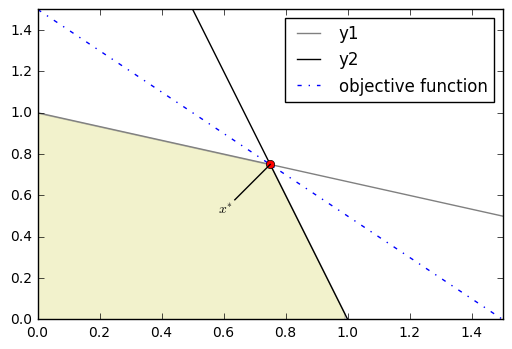

In [2]:
# 例：単純な線形計画問題をSUMTで解いてみる

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from math import *
from pylab import *

fig, ax = plt.subplots()

x = np.arange(0, 5, 0.01)
y1 = 1 - (1/3) * x
y2 = 3 - 3 * x
y3 = 1.5 - x
z = minimum(y1, y2)

ax.fill_between(x, z, 0, z>0, facecolor='y', alpha=0.2)

ax.set_xlim(0, 1.5)
ax.set_ylim(0, 1.5)

ax.plot(x, y1, color="gray", label='y1', ls='-')
ax.plot(x, y2, color="k", label='y2', ls='-')
ax.plot(x, y3, color='b', ls='-.', label='objective function')
ax.plot(0.75, 0.75, 'ro')
ax.text(0.75, 0.75, str(r'$x^{*}$'), withdash=True, dashlength=50, dashrotation=45)
plt.legend()
#plt.savefig('image/simple_plot0.png')
plt.plot()

元問題：
$$ \max_{x, y} x + y \\ \frac{1}{3}x + y - 1 \leq 0 \\ 3x + y - 3 \leq 0 \\ x,y \geq 0$$

バリア関数を用いて目的関数を変換：

$$ \max_{x,y} \phi(x,y ; \lambda) = x + y + \lambda \cdot ( \log(-\frac{1}{3}x - y + 1) + \log(-3x - y + 3) + \log(x) + \log(y) ) $$

In [5]:
import numpy as np
from scipy.optimize import minimize, newton

def objectiveFunction(x):
    l = 10
    f = - x[0] - x[1] - l*(np.log(-(1/3)*x[0] - x[1] + 1) + np.log(-3*x[0] - x[1] + 3) + np.log(x[0]) + np.log(x[1]))
    return f

In [14]:
# 非線形最適化なので、newton法などを用いる必要あり
# なぜうまくいかないのか・・・
x0 = [0.1, 0.1]
res = minimize(objectiveFunction, x0)
print(res)

      fun: nan
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([ nan,  nan])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 448
      nit: 1
     njev: 112
   status: 2
  success: False
        x: array([ 731.41811737,  731.41811737])


/Users/KYO/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log
/Users/KYO/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log
/Users/KYO/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log


In [11]:
def y1(x):
    f = np.log(-(1/3)*x[0] - x[1] + 1)
    return f

In [12]:
y1(x0)

-1.6094379124341001

In [15]:
def y2(x):
    f = np.log(-3*x[0] - x[1] + 3)
    return f

In [16]:
y2(x0)

-0.5108256237659905

In [17]:
np.log(x0[0])

-0.51082562376599072

In [18]:
np.log(x0[1])

-0.51082562376599072

In [84]:
# 一変数の例
def func(x):
    l = 2
    f = x + 1 - l*np.log(x)
    return f

In [93]:
x0 = [1]
res = minimize(func, x0, method="powell")
print(res.x)

2.0000000000629514


In [114]:
df = np.arange(0, 2, 0.05)
x0 = 1

In [116]:
for i in df:
    res = minimize(lambda x : x + 1 - (2 - i)*np.log(x), x0)
    print(res.x)

[ 1.99999999]
[ 1.94999999]
[ 1.89999999]
[ 1.84999998]
[ 1.79999998]
[ 1.74999999]
[ 1.69999999]
[ 1.64999999]
[ 1.59999999]
[ 1.54999998]
[ 1.49999999]
[ 1.44999999]
[ 1.39999999]
[ 1.34999999]
[ 1.3]
[ 1.24999999]
[ 1.19999999]
[ 1.14999999]
[ 1.09999999]
[ 1.05]
[ 1.]
[ 0.94999999]
[ 0.90000001]
[ 0.84999999]
[ 0.79999998]
[ 0.75]
[ 0.69999999]
[ 0.65000001]
[ 0.59999999]
[ 0.54999998]
[ 0.5]
[ 0.44999999]
[ 0.40000001]
[ 0.34999999]
[ 0.30000001]
[ 0.25]
[ 0.19999999]
[ 0.15000001]
[ 0.09999999]
[ 0.05000001]


In [46]:
from math import *
log(1)

0.0